In [1]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import yaml

# Plots

This notebook collects an extended analysis of the results of the RT computations.

## Analysis of the echo peaks 

We analyze the properties of the echo peaks in function of $\tau$.

This analysis is useful to assess the efficiency of the echo signal retrieval and to compare the numerical results with
the ones derived from the analytical perturbation theory

In [50]:
file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e3_2e2.yaml'
file_pol = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/1.5ps-direct-decay-int_1e3_2e2/o-1.5ps-direct-decay-int_1e3_2e2.polarization'
int_str = '1e3_2e2'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e4_2e3.yaml'
#int_str = '1e4_2e3'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e4_1e4.yaml'
#int_str = '1e4_1e4'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e4_1e4_extended-bands.yaml'
#int_str = '1e4_1e4_extended-bands'

eta = 4e-1

In [3]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [51]:
polarization = P.YamboOutputParser([file_pol])['polarization']
polarization.keys()

Parse file RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/1.5ps-direct-decay-int_1e3_2e2/o-1.5ps-direct-decay-int_1e3_2e2.polarization


dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [5]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']
echo_peak_vals = [1,2,3,4,5]

In [6]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

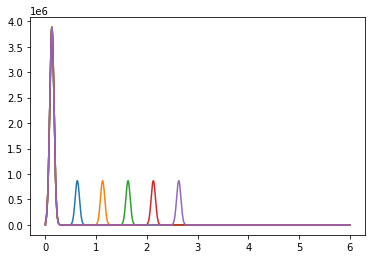

In [7]:
for t in tau:
    plt.plot(time,profile[t])

In [8]:
ind_max = argrelextrema(profile['2ps'],np.greater,order=2)[0]
profile['2ps'][ind_max][0]/profile['2ps'][ind_max][1]

4.471977566159309

In [10]:
# actually the profile of the first peak is overstimated of a factor 2 (due to an error in ymabo)
2*np.sqrt(1000/200)

4.47213595499958

We build the expected exponential decay of the polarization, starting from the its peak

In [11]:
ind_max = np.argmax(px_ref)
pol_peak = px_ref[ind_max]
time_exp = time[ind_max:]
exp_decay = pol_peak*np.exp(-eta*(time_exp-time_exp[0]))

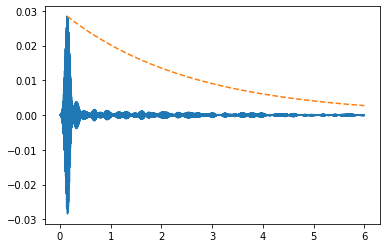

In [12]:
plt.plot(time,px_ref)
plt.plot(time_exp,exp_decay,linestyle='--')

In [13]:
time_exp[0],pol_peak

(0.14300000000000002, 0.0284330914)

We perform a gaussian fit of the first peak to estimate its properties

In [14]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [15]:
ind_max = argrelextrema(px_ref,np.greater,order=3)[0]
time_env = time[ind_max]
px_ref_env = px_ref[ind_max]

(0.0, 0.5)

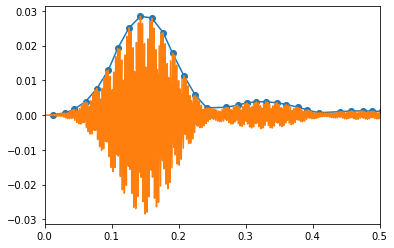

In [16]:
plt.plot(time_env,px_ref_env)
plt.scatter(time_env,px_ref_env)
plt.plot(time,px_ref)
plt.xlim(0,0.5)

In [17]:
ind_max = np.argmax(px_ref_env)
px_ref_env_max = px_ref_env[ind_max]
mean = time_env[ind_max]
ampl = px_ref_env_max
sigma = 0.04
p0 = [px_ref_env_max,mean,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_env,p0=p0)
p0,gauss_pars_ref

([0.0284330914, 0.14300000000000002, 0.04],
 array([0.0288505 , 0.14876859, 0.04326971]))

(0.0, 0.5)

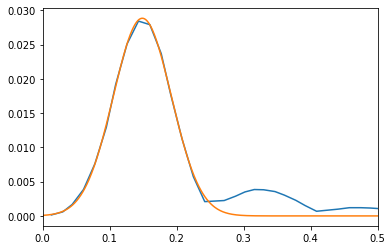

In [18]:
plt.plot(time_env,px_ref_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
plt.xlim(0,0.5)

The width of the peak is the same of the profile of the pulse and the maximum is located at 149 fs, that is
around 20 fs after the peak of the profile.

We rescale the echo and the profile arrays, so that the maximum is set to 1

In [19]:
echo_max = max(echo[tau[0]])
profile_max = max(profile[tau[0]])
for t in tau:
    echo[t] = echo[t]/echo_max
    profile[t] = profile[t]/profile_max

We rescale the first peak of the profile for better plot visualization. We choose a factor 2 in the second peak to correct
the error of the profile due to the bug in yambo

In [20]:
ind_rescale = np.where(time > 0.4)[0][0]
rescale_profile = np.zeros([len(time)])
rescale_profile[:ind_rescale] = 1
rescale_profile[ind_rescale:] = 2 
rescale_profile

array([1., 1., 1., ..., 2., 2., 2.])

We compute the maximum of the profile of the echo pulse

In [21]:
tmax_profile = {}
for t in tau:
    signal = profile[t]
    ind_max = argrelextrema(signal,np.greater,order=2)[0][1]
    tmax_profile[t] = time[ind_max]
tmax_profile

{'0.5ps': 0.629,
 '1ps': 1.127,
 '1.5ps': 1.629,
 '2ps': 2.1270000000000002,
 '2.5ps': 2.629}

In [22]:
time_profile = np.array([tmax_profile[i] for i in tau])
time_profile

array([0.629, 1.127, 1.629, 2.127, 2.629])

We define a procedure that perform a gaussian fit of the echo signal

In [23]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [24]:
gauss_pars = {}

for t,p in zip(tau,echo_peak_vals):
    signal = echo[t]
    # build the envelope of the signal
    ind_max = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_max]
    time_env = time[ind_max]
    # perform the fit
    mean = p
    sigma = 0.100
    popt,pcov = curve_fit(gauss,time_env,values_env,p0=[1,mean,sigma])
    gauss_pars[t] = popt
gauss_pars

{'0.5ps': array([0.98816126, 1.1289835 , 0.07979057]),
 '1ps': array([0.62001319, 2.12099248, 0.08726575]),
 '1.5ps': array([0.38027569, 3.12860226, 0.09169465]),
 '2ps': array([0.25464567, 4.11902559, 0.09216832]),
 '2.5ps': array([0.17695087, 5.12383984, 0.08713958])}

In [25]:
time_echo = np.array([gauss_pars[t][1] for t in tau])
theta_echo = echo_max*np.array([np.sqrt(2*np.pi)*gauss_pars[t][0]*gauss_pars[t][2] for t in tau]) # rescale times echo_max
time_echo

array([1.1289835 , 2.12099248, 3.12860226, 4.11902559, 5.12383984])

We can compute the distance between the max of the profile of the echo peak and the position of the max (according to a gaussian fit)
of the echo pulse

In [26]:
for t in tau:
    diffe = gauss_pars[t][1]-tmax_profile[t]
    print(t,diffe)

0.5ps 0.4999834974969286
1ps 0.9939924818189116
1.5ps 1.499602264397358
2ps 1.9920255872247004
2.5ps 2.494839836509741


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

We fit the echo areas with a simple exponential decay and compute the echo efficiency 
$$
\theta_{echo}(t) = \theta_{ref}\lambda e^{-\eta(t-t_0)}
$$
where $\lambda$ is the efficiency of the echo retrieval and $t_0$ is the time position of the first peak

In [27]:
theta_ref = np.sqrt(2*np.pi)*gauss_pars_ref[0]*gauss_pars_ref[2]
t0 = gauss_pars_ref[1]

In [28]:
def monoExp(t, l):
    return theta_ref*l*np.exp(-eta*(t-t0))

In [29]:
l0 = 1e-2 # start with values near those we expect
params, cv = curve_fit(monoExp, time_echo, theta_echo, l0)
l = params[0]
l

0.017855891372257147

508.8799234126034


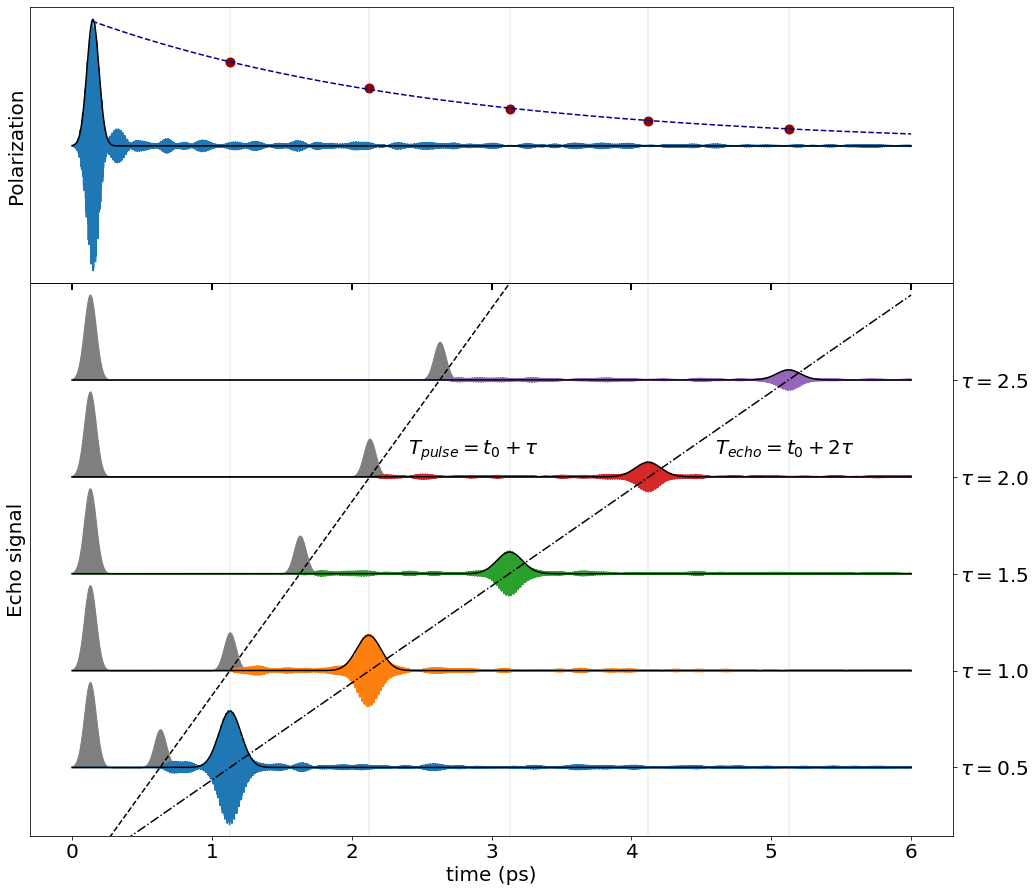

In [30]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
a_profile = 4*shift/(time_profile[-1]-time_profile[0])
b_profile = -a_profile*time_profile[0]
a_echo = 4*shift/(time_echo[-1]-time_echo[0])
b_echo = -a_echo*time_echo[0]
scatter_rescale = max(px_ref)/(theta_ref*l)
print(scatter_rescale)

ypos=0

fig, ax1 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,2]) 
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])

for t in tau:
    ax1.plot(time,ypos+echo[t]) #,color='tab:orange'
    ax1.fill_between(time,ypos+1.5*profile[t]*rescale_profile,ypos,color='tab:grey')
    ax1.plot(time,ypos+gauss(time,*gauss_pars[t]),color='black',linestyle='-')
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
ax1.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax1.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

ax1.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax1.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2.scatter(time_echo,scatter_rescale*theta_echo,linewidth=4,color='darkred')
ax2.plot(time,px_ref)
ax2.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax2.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
for t in tau:
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax2.axhline(0,color='black',linestyle='-')
#ax2.set_xticks([])
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.tick_params(width=2,length=7)
ax2.set_ylabel('Polarization',size=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%int_str,format='eps',bbox_inches = "tight")

where $t_0$=129 fs.

We add also the plot of the polarization with a double pulse for a single $\tau$

508.8799234126034


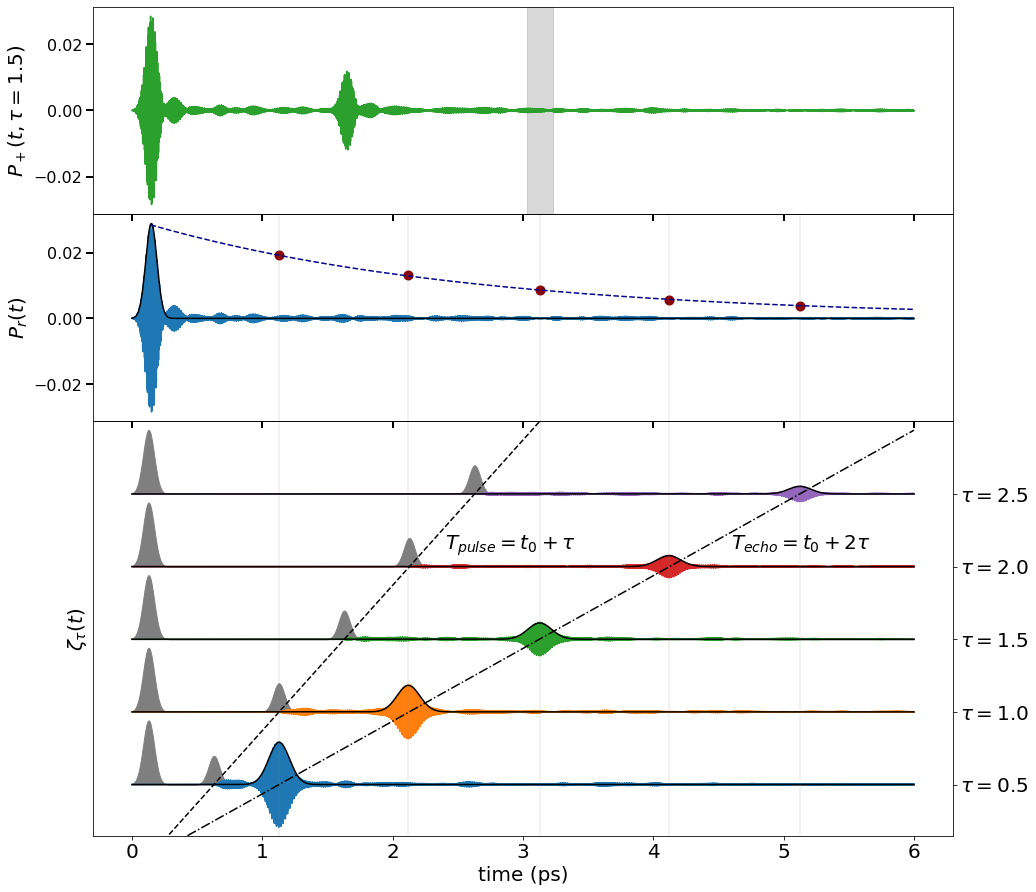

In [53]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
a_profile = 4*shift/(time_profile[-1]-time_profile[0])
b_profile = -a_profile*time_profile[0]
a_echo = 4*shift/(time_echo[-1]-time_echo[0])
b_echo = -a_echo*time_echo[0]
scatter_rescale = max(px_ref)/(theta_ref*l)
print(scatter_rescale)

ypos=0

fig, ax1 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,2]) 
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[0])

for t in tau:
    ax1.plot(time,ypos+echo[t]) #,color='tab:orange'
    ax1.fill_between(time,ypos+1.5*profile[t]*rescale_profile,ypos,color='tab:grey')
    ax1.plot(time,ypos+gauss(time,*gauss_pars[t]),color='black',linestyle='-')
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
ax1.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax1.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

ax1.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax1.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('$\zeta_{\\tau}(t)$',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2.scatter(time_echo,scatter_rescale*theta_echo,linewidth=4,color='darkred')
ax2.plot(time,px_ref)
ax2.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax2.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
for t in tau:
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax2.axhline(0,color='black',linestyle='-')
#ax2.set_xticks([])
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels([])
#ax2.set_yticks([])
ax2.tick_params(width=2,length=7,labelsize=16)
ax2.tick_params(width=2,length=7)
ax2.set_ylabel('$P_r(t)$',size=label_size)

ax3.plot(time,polarization['Pol_x'],color='tab:green')
ax3.axvspan(gauss_pars['1.5ps'][1]-0.1, gauss_pars['1.5ps'][1]+0.1, alpha=0.3, color='tab:grey')
ax3.set_xticks([0,1,2,3,4,5,6])
ax3.set_xticklabels([])
#ax3.set_yticks([])
ax3.tick_params(width=2,length=7,labelsize=16)
ax3.set_ylabel('$P_+(t,\\tau=1.5)$',size=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%int_str,format='eps',bbox_inches = "tight")

In [79]:
# the shape is consistent with a delay 2*tau
a_echo/a_profile

0.500643785476959